In [1]:
%reset
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Machine Learning Engineering Nanodegree
## Project: Onde devo gastar o meu dinheiro?

## Criando base de dados

O objetivo é criar uma tabela contendo dados do crescimento do IFDM de 2012 em relação a 2011, população das cidades e gastos das cidades em cada uma das subáreas. A tabela objetivo está rotulada como gastos_ifdm_dif.

In [2]:
# Importando metodos e pacotes

import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.decomposition import PCA
import visuals as vs

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

from pandas.tools.plotting import scatter_matrix

In [3]:
# Importando bases de dados

# Gastos por funcao no ano de 2012
gastos_2012 = pd.read_csv("Data/Despesas por funcao/despesaFuncao2012.csv", encoding="utf-8")

# Codigos de identificacao dos estados e municipios
codigo_municipio = pd.read_csv("Data/Codigo municipal/CodMun2012.csv", encoding='utf-8')
codigo_estado = pd.read_csv("Data/Codigo UF/CodUF2012.csv", encoding='utf-8')

# IFDM por categoria de 2005 a 2013
ifdm_geral_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_geral_2005-2013.csv", encoding="utf_8", sep=";")
ifdm_saude_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_saude_2005-2013.csv", encoding="utf_8", sep=";")
ifdm_empregoRenda_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_empregoRenda_2005-2013.csv", encoding="utf_8", sep=";")
ifdm_educacao_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_educacao_2005-2013.csv", encoding="utf_8", sep=";")

# Metricas municipais em 2010 (IDH)
municipios_metricas = pd.read_csv("Data/Municipios/municipios.csv", encoding="utf-8", sep=";", decimal=",")

In [4]:
# Criando uma tabela para consulta de cidade e estado
estado_municipio = pd.merge(codigo_municipio, codigo_estado, how='inner', left_on=["CD_UF"], right_on=["CD_UF"])

In [5]:
# Filtra apenas os municipios com metricas mais recentes e busca apenas as colunas de interesse
municipio_populacao = municipios_metricas.loc[municipios_metricas['ANO'] == municipios_metricas['ANO'].max(), ['Municipio','UF','POP']]

# Trocando codigo de estado pelo nome do estado em municipio_ 
municipio_populacao = codigo_estado.merge(municipio_populacao, left_on=["CD_UF"], right_on=["UF"])
municipio_populacao.drop(['CD_UF', 'UF_y', 'ESTADO'], axis = 1, inplace = True)
municipio_populacao.rename(columns={'UF_x':'UF', 'POP':'Populacao'}, inplace=True)

display(municipio_populacao.head())

UF              Municipio  Populacao
0  RO  ALTA FLORESTA D'OESTE      24097
1  RO              ARIQUEMES      89766
2  RO                 CABIXI       6303
3  RO                 CACOAL      78141
4  RO             CEREJEIRAS      16942

In [6]:
# Cria tabela de porcentagens de gastos pelo total de gastos
uf_cod_mun = gastos_2012.loc[:,['UF','Cod Mun']]

gastos_2012 = gastos_2012.drop(['UF','Cod Mun'], axis=1)
total_gastos = gastos_2012.pop('Total Geral da Despesa por Funcao')

gastos_2012_percent = gastos_2012.div(total_gastos, axis=0)

# Remonta tabela de gastos inicial
gastos_2012_mun = pd.concat([gastos_2012, total_gastos, uf_cod_mun], axis=1)

# Concatena gastos ao municipio
gastos_2012_mun_percent = pd.concat([gastos_2012_percent, uf_cod_mun], axis=1)

In [7]:
# Adicionando nome da cidade e estado à tabela de gastos_2012
gastos_2012_mun_percent = gastos_2012_mun_percent.merge(estado_municipio, how='inner', left_on=["Cod Mun", "UF"], right_on=["CD_MUN", "CD_UF"])
gastos_2012_mun_percent.drop(['CD_UF', 'CD_MUN', 'UF_x', 'Cod Mun', 'ESTADO'], axis = 1, inplace = True)
gastos_2012_mun_percent.rename(columns={'UF_y':'UF', 'MUNICIPIO':'Municipio'}, inplace=True)

In [8]:
# Criando tabela de IFDM 
conditions = ['Codigo','Regiao','UF','Municipio']
ifdm = ifdm_geral_ano_base_2005_2013.merge(ifdm_saude_ano_base_2005_2013,on=conditions).merge(ifdm_empregoRenda_ano_base_2005_2013,on=conditions).merge(ifdm_educacao_ano_base_2005_2013,on=conditions)

# Removendo cidades sem algum valor de IFDM em algum ano
ifdm = ifdm.dropna()

# Calcula diferença do IFDM de 2012 e 2011
ifdm['ifdm_dif_saude'] = ifdm['2012_saude_nota'] - ifdm['2011_saude_nota']
ifdm['ifdm_dif_empregoRenda'] = ifdm['2012_empregoRenda_nota'] - ifdm['2011_empregoRenda_nota']
ifdm['ifdm_dif_educacao'] = ifdm['2012_educacao_nota'] - ifdm['2011_educacao_nota']
ifdm['ifdm_dif_geral'] = ifdm['2012_geral_nota'] - ifdm['2011_geral_nota']

# Filtra apenas colunas de interesse
ifdm_dif = ifdm[['Municipio','UF','Regiao','ifdm_dif_saude','ifdm_dif_empregoRenda','ifdm_dif_educacao','2012_saude_nota','2012_empregoRenda_nota','2012_educacao_nota']]
#,'ifdm_dif_geral','2012_geral_nota'

In [9]:
def remove_acentos(df, coluna):
    sem_acentos = df[coluna].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    df.loc[:,coluna] = sem_acentos
    return df

# remove acentos dos nomes das cidades
gastos_2012_mun_percent = remove_acentos(gastos_2012_mun_percent, "Municipio")
ifdm_dif = remove_acentos(ifdm_dif, "Municipio")
municipio_populacao = remove_acentos(municipio_populacao, "Municipio")

/home/allan/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
def letras_minusculas(df, coluna):
    minusculas = df[coluna].str.lower()
    df.loc[:,coluna] = minusculas
    return df

# Coloca todas as cidades em letras minusculas
gastos_2012_mun_percent = letras_minusculas(gastos_2012_mun_percent, "Municipio")
ifdm_dif = letras_minusculas(ifdm_dif, "Municipio")
municipio_populacao = letras_minusculas(municipio_populacao, "Municipio")

In [11]:
# Adiciona ifdm_dif a tabela de gastos
## TODO: checar a diferenca de municipios esperada (algo perto de 5560 para a obtida de 4733)
gastos_ifdm_dif = ifdm_dif.merge(gastos_2012_mun_percent, on=["Municipio","UF"])

# Renomeia algumas colunas
gastos_ifdm_dif.rename(columns={'Demais Subfuncoes 10':'Demais Subfuncoes Saude', 'Demais Subfuncoes 11':'Demais Subfuncoes Emprego','Demais Subfuncoes 12':'Demais Subfuncoes Educacao'}, inplace=True)

# Filtra features relacionadas a investimentos em trabalho, saude e educacao
gastos_ifdm_dif = gastos_ifdm_dif.loc[:,['ifdm_dif_saude','ifdm_dif_empregoRenda','ifdm_dif_educacao','2012_saude_nota','2012_empregoRenda_nota','2012_educacao_nota','Regiao','UF','Municipio','Saude','Atencao Basica','Assistencia Hospitalar','Suporte Profilatico','Vigilancia Sanitaria','Vigilancia Epidemiologica','Alimentacao e Nutricao','Demais Subfuncoes Saude','Trabalho','Protecao ao Trabalhador','Relacoes de Trabalho','Empregabilidade','Fomento ao Trabalho','Demais Subfuncoes Emprego','Educacao','Ensino Fundamental','Ensino Medio','Ensino Profissional','Ensino Superior','Educacao Infantil','Educacao de Jovens e Adultos','Educacao Especial','Demais Subfuncoes Educacao']]
#'ifdm_dif_geral','2012_geral_nota',

In [12]:
# Adiciona populacao a tabela de gastos
gastos_ifdm_dif = gastos_ifdm_dif.merge(municipio_populacao, on=["Municipio","UF"])

display(gastos_ifdm_dif.head())

ifdm_dif_saude  ifdm_dif_empregoRenda  ifdm_dif_educacao  2012_saude_nota  \
0          0.0188                 0.0071            -0.0499           0.5759   
1          0.0096                -0.0136             0.0509           0.8373   
2          0.0285                 0.0091             0.0048           0.6419   
3          0.0376                 0.0589             0.0128           0.8258   
4         -0.0265                 0.2018            -0.0096           0.5596   

   2012_empregoRenda_nota  2012_educacao_nota Regiao  UF  \
0                  0.4499              0.6329  Norte  RO   
1                  0.6393              0.7606  Norte  RO   
2                  0.4650              0.7462  Norte  RO   
3                  0.7353              0.7169  Norte  RO   
4                  0.6370              0.7308  Norte  RO   

               Municipio     Saude    ...      Educacao  Ensino Fundamental  \
0  alta floresta d'oeste  0.261469    ...      0.274639            0.262958   
1              ariquemes  0.255858    ...      0.349965            0.255520   
2                 cabixi  0.238406    ...      0.322385            0.301011   
3                 cacoal  0.268643    ...      0.241181            0.160456   
4             cerejeiras  0.271466    ...      0.236343            0.194852   

   Ensino Medio  Ensino Profissional  Ensino Superior  Educacao Infantil  \
0      0.000000                  0.0         0.000000           0.011680   
1      0.000000                  0.0         0.000047           0.020875   
2      0.000000                  0.0         0.000000           0.021373   
3      0.000000                  0.0         0.000000           0.052628   
4      0.013269                  0.0         0.000000           0.027081   

   Educacao de Jovens e Adultos  Educacao Especial  \
0                      0.000000           0.000000   
1                      0.003275           0.000000   
2                      0.000000           0.000000   
3                      0.000000           0.000674   
4                      0.000000           0.001141   

   Demais Subfuncoes Educacao  Populacao  
0                    0.000000      24097  
1                    0.070247      89766  
2                    0.000000       6303  
3                    0.027423      78141  
4                    0.000000      16942  

[5 rows x 33 columns]

In [13]:
# Categoriza o tamanho das cidades pela populacao
gastos_ifdm_dif['Tamanho'] = np.where(gastos_ifdm_dif['Populacao'] < 50000, 'Pequena', 
        np.where(gastos_ifdm_dif['Populacao'] < 100000, 'Media-pequena',
                np.where(gastos_ifdm_dif['Populacao'] < 300000, 'Media',
                        np.where(gastos_ifdm_dif['Populacao'] < 500000, 'Media-grande',
                                np.where(gastos_ifdm_dif['Populacao'] < 1000000, 'Grande', 'Metropole')))))

# Análise descritiva


In [14]:
# Dados
display(gastos_ifdm_dif.head())

ifdm_dif_saude  ifdm_dif_empregoRenda  ifdm_dif_educacao  2012_saude_nota  \
0          0.0188                 0.0071            -0.0499           0.5759   
1          0.0096                -0.0136             0.0509           0.8373   
2          0.0285                 0.0091             0.0048           0.6419   
3          0.0376                 0.0589             0.0128           0.8258   
4         -0.0265                 0.2018            -0.0096           0.5596   

   2012_empregoRenda_nota  2012_educacao_nota Regiao  UF  \
0                  0.4499              0.6329  Norte  RO   
1                  0.6393              0.7606  Norte  RO   
2                  0.4650              0.7462  Norte  RO   
3                  0.7353              0.7169  Norte  RO   
4                  0.6370              0.7308  Norte  RO   

               Municipio     Saude      ...        Ensino Fundamental  \
0  alta floresta d'oeste  0.261469      ...                  0.262958   
1              ariquemes  0.255858      ...                  0.255520   
2                 cabixi  0.238406      ...                  0.301011   
3                 cacoal  0.268643      ...                  0.160456   
4             cerejeiras  0.271466      ...                  0.194852   

   Ensino Medio  Ensino Profissional  Ensino Superior  Educacao Infantil  \
0      0.000000                  0.0         0.000000           0.011680   
1      0.000000                  0.0         0.000047           0.020875   
2      0.000000                  0.0         0.000000           0.021373   
3      0.000000                  0.0         0.000000           0.052628   
4      0.013269                  0.0         0.000000           0.027081   

   Educacao de Jovens e Adultos  Educacao Especial  \
0                      0.000000           0.000000   
1                      0.003275           0.000000   
2                      0.000000           0.000000   
3                      0.000000           0.000674   
4                      0.000000           0.001141   

   Demais Subfuncoes Educacao  Populacao        Tamanho  
0                    0.000000      24097        Pequena  
1                    0.070247      89766  Media-pequena  
2                    0.000000       6303        Pequena  
3                    0.027423      78141  Media-pequena  
4                    0.000000      16942        Pequena  

[5 rows x 34 columns]

In [15]:
# Descricao dos dados pelo tamanho da cidade
g = gastos_ifdm_dif.groupby('Tamanho')

display(g.describe())

2012_educacao_nota  2012_empregoRenda_nota  \
Tamanho                                                           
Grande        count           23.000000               23.000000   
              mean             0.763557                0.743678   
              std              0.122712                0.057770   
              min              0.536900                0.610000   
              25%              0.652550                0.718100   
              50%              0.789400                0.765500   
              75%              0.866900                0.784650   
              max              0.929700                0.814800   
Media         count          186.000000              186.000000   
              mean             0.774097                0.712705   
              std              0.112689                0.103551   
              min              0.526500                0.408800   
              25%              0.686700                0.655650   
              50%              0.787350                0.742000   
              75%              0.864075                0.784500   
              max              0.974300                0.893300   
Media-grande  count           40.000000               40.000000   
              mean             0.772825                0.735743   
              std              0.113910                0.083223   
              min              0.594600                0.522600   
              25%              0.654000                0.703825   
              50%              0.778200                0.764950   
              75%              0.865550                0.796375   
              max              0.969800                0.845500   
Media-pequena count          301.000000              301.000000   
              mean             0.724968                0.622176   
              std              0.130989                0.135833   
              min              0.414400                0.225900   
              25%              0.628700                0.515200   
              50%              0.722800                0.616400   
              75%              0.832400                0.740400   
              max              0.982500                0.874700   
Metropole     count           14.000000               14.000000   
              mean             0.765429                0.767750   
              std              0.098218                0.026429   
              min              0.603100                0.725400   
              25%              0.693950                0.747875   
              50%              0.755250                0.766150   
              75%              0.836100                0.793950   
              max              0.906400                0.801700   
Pequena       count         3920.000000             3920.000000   
              mean             0.723732                0.482491   
              std              0.121651                0.121060   
              min              0.271400                0.121400   
              25%              0.637325                0.396000   
              50%              0.734100                0.466050   
              75%              0.811125                0.561750   
              max              1.000000                0.880300   

                     2012_saude_nota  Alimentacao e Nutricao  \
Tamanho                                                        
Grande        count        23.000000               23.000000   
              mean          0.836570                0.000084   
              std           0.075541                0.000286   
              min           0.679500                0.000000   
              25%           0.795900                0.000000   
              50%           0.847800                0.000000   
              75%           0.910900                0.000000   
              max           0.938100                0.001356   
Media         count       186.

In [61]:
# Utilizacao de cidades medias, media-grandes, grandes e metropoles no estudo
cidades_300_mais_hab = gastos_ifdm_dif.loc[gastos_ifdm_dif['Tamanho'].isin(['Metropole','Grande','Media-grande','Media'])]
n_cidades = len(cidades_300_mais_hab)
print "Numero de cidades na base: {}".format(n_cidades)

Numero de cidades na base: 263


In [62]:
print "Cidades por estado: "
print cidades_300_mais_hab['UF'].value_counts()

Cidades por estado: 
SP    73
RJ    23
MG    23
RS    18
PR    17
BA    15
SC    12
PE    12
ES     9
CE     8
GO     8
PA     7
MA     7
PB     4
MT     4
MS     4
RN     3
AL     2
AP     2
SE     2
RO     2
PI     2
TO     2
AM     2
RR     1
AC     1
Name: UF, dtype: int64


In [63]:
print "Cidades por regiao: "
print cidades_300_mais_hab['Regiao'].value_counts()

display(cidades_300_mais_hab.head())

Cidades por regiao: 
Sudeste         128
Nordeste         55
Sul              47
Norte            17
Centro-Oeste     16
Name: Regiao, dtype: int64


ifdm_dif_saude  ifdm_dif_empregoRenda  ifdm_dif_educacao  2012_saude_nota  \
11          0.0339                -0.0035             0.0082           0.6752   
16          0.0264                -0.1000             0.0152           0.7503   
59          0.0232                -0.0261             0.0198           0.7610   
82         -0.0082                -0.0381             0.0076           0.6791   
87          0.0373                -0.0220             0.0003           0.6874   

    2012_empregoRenda_nota  2012_educacao_nota Regiao  UF    Municipio  \
11                  0.7418              0.6866  Norte  RO    ji-parana   
16                  0.7279              0.6591  Norte  RO  porto velho   
59                  0.7639              0.7208  Norte  AC   rio branco   
82                  0.7484              0.6490  Norte  AM       manaus   
87                  0.4929              0.7602  Norte  AM    parintins   

       Saude      ...       Ensino Fundamental  Ensino Medio  \
11  0.325083      ...                 0.196993      0.000000   
16  0.236718      ...                 0.174298      0.000000   
59  0.169282      ...                 0.176190      0.000000   
82  0.203095      ...                 0.214369      0.000000   
87  0.251144      ...                 0.333794      0.000606   

    Ensino Profissional  Ensino Superior  Educacao Infantil  \
11                  0.0         0.001179           0.013021   
16                  0.0         0.000000           0.020425   
59                  0.0         0.000000           0.012034   
82                  0.0         0.002727           0.034156   
87                  0.0         0.000235           0.049651   

    Educacao de Jovens e Adultos  Educacao Especial  \
11                      0.000000           0.000595   
16                      0.002704           0.000128   
59                      0.000000           0.000000   
82                      0.003963           0.000686   
87                      0.000000           0.000000   

    Demais Subfuncoes Educacao  Populacao       Tamanho  
11                    0.003432     115896         Media  
16                    0.032065     422555  Media-grande  
59                    0.000000     333052  Media-grande  
82                    0.010063    1793443     Metropole  
87                    0.012355     101218         Media  

[5 rows x 34 columns]

In [64]:
# Separa so os gastos de cada cidade

gastos = cidades_300_mais_hab.copy()
gastos.drop(['ifdm_dif_saude','ifdm_dif_empregoRenda','ifdm_dif_educacao','2012_saude_nota','2012_empregoRenda_nota','2012_educacao_nota','Regiao','UF','Municipio','Tamanho','Populacao'], axis = 1, inplace = True)
#,'ifdm_dif_geral','2012_geral_nota'

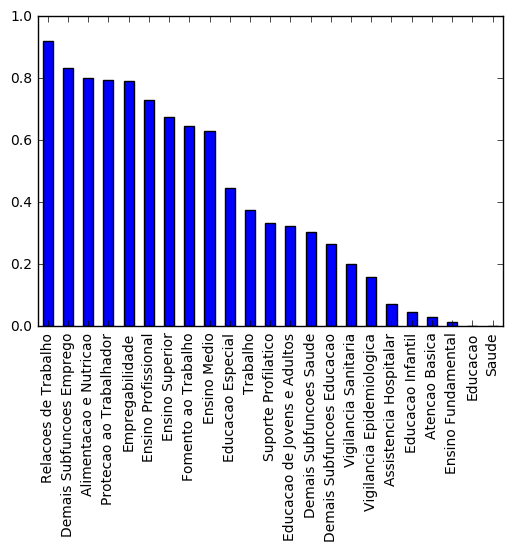

In [65]:
total_ocorrencias = gastos[gastos == 0].count()
porcentagem_ocorrencias = total_ocorrencias/n_cidades
porcentagem_ocorrencias = porcentagem_ocorrencias.sort_values(ascending=False)

porcentagem_ocorrencias.plot.bar();

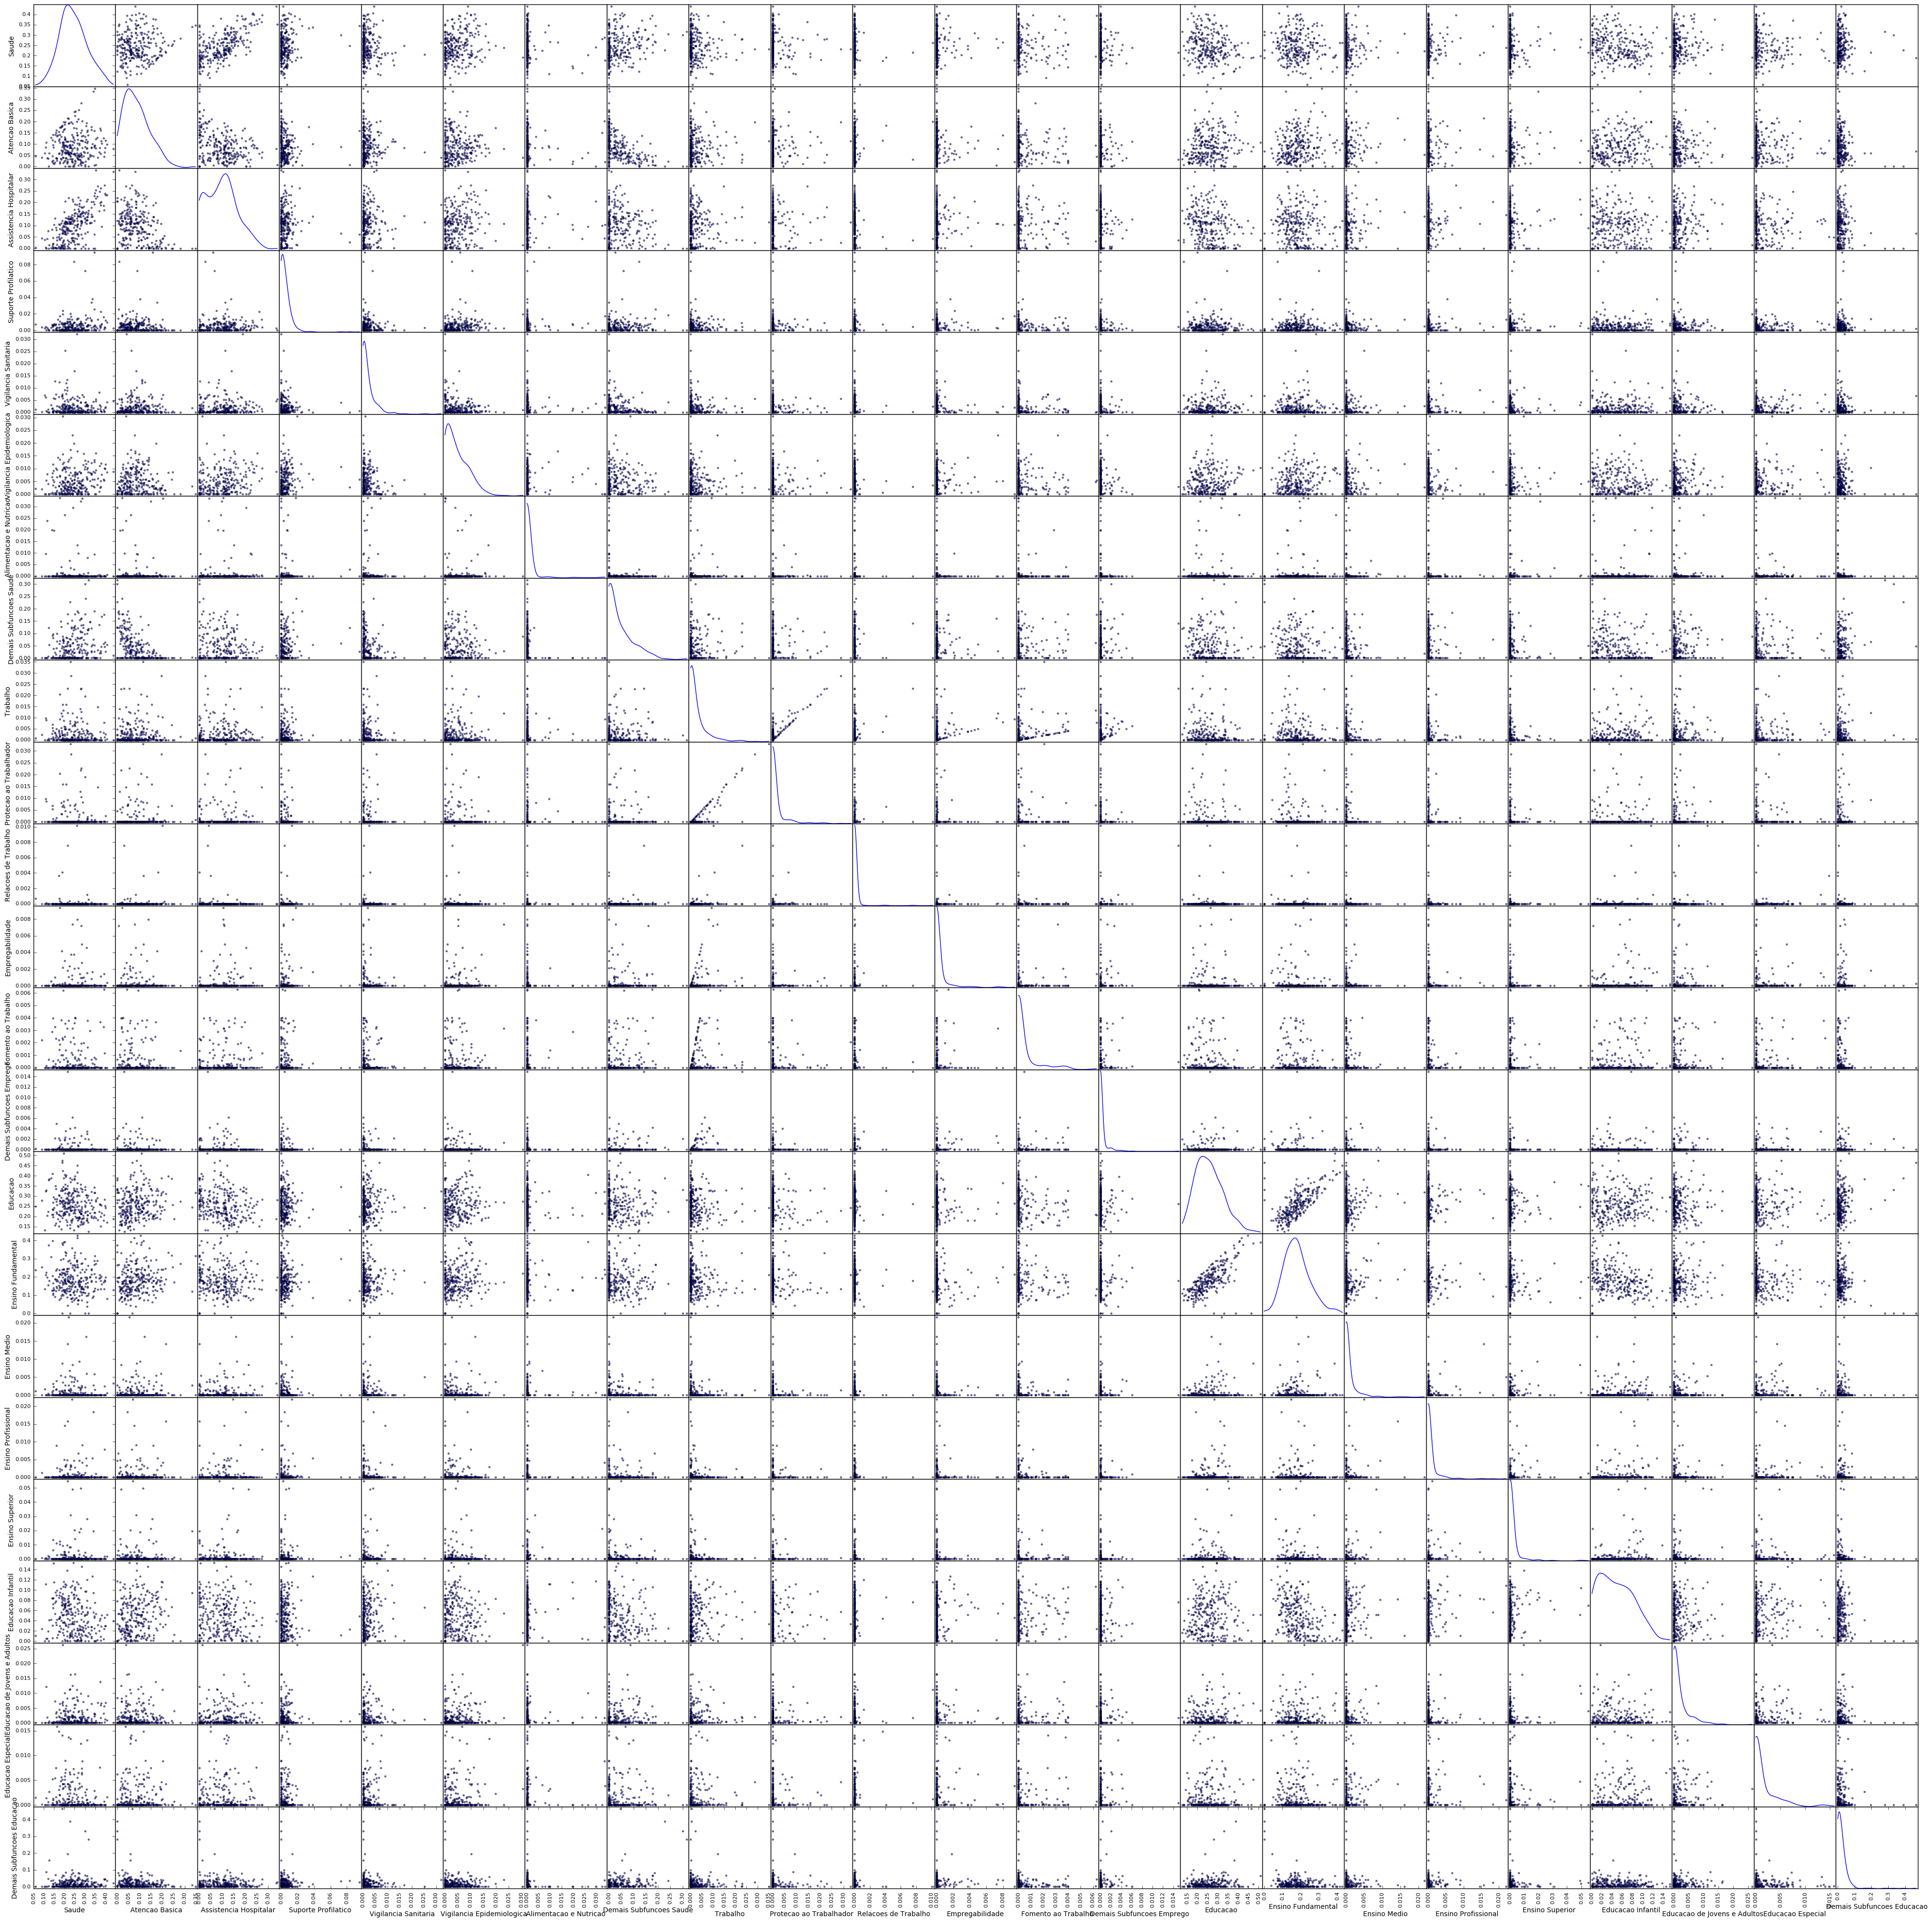

In [66]:
# Produz um scatterplot para cada par de features
scatter_matrix(gastos, figsize=(50, 50), diagonal='kde');

## Pré-processamento

In [67]:
# Encontra cidades que nao descreveram os gastos de acordo com o esperado e devem ser removidas da pesquisa
para_remover = gastos[gastos.Trabalho == 0.0].index
para_remover.append(gastos[gastos.Educacao == 0.0].index)
para_remover.append(gastos[gastos.Saude == 0.0].index)
len(para_remover)

99

In [68]:
# Remove cidades das bases utilizadas
cidades_300_mais_hab = cidades_300_mais_hab[~cidades_300_mais_hab.index.isin(para_remover)]
gastos = gastos[~gastos.index.isin(para_remover)]

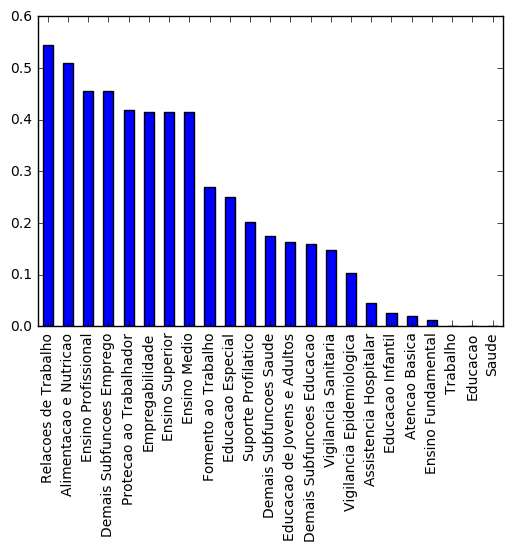

In [69]:
# Print ocorrencias de zeros
total_ocorrencias = gastos[gastos == 0].count()
porcentagem_ocorrencias = total_ocorrencias/n_cidades
porcentagem_ocorrencias = porcentagem_ocorrencias.sort_values(ascending=False)

porcentagem_ocorrencias.plot.bar();

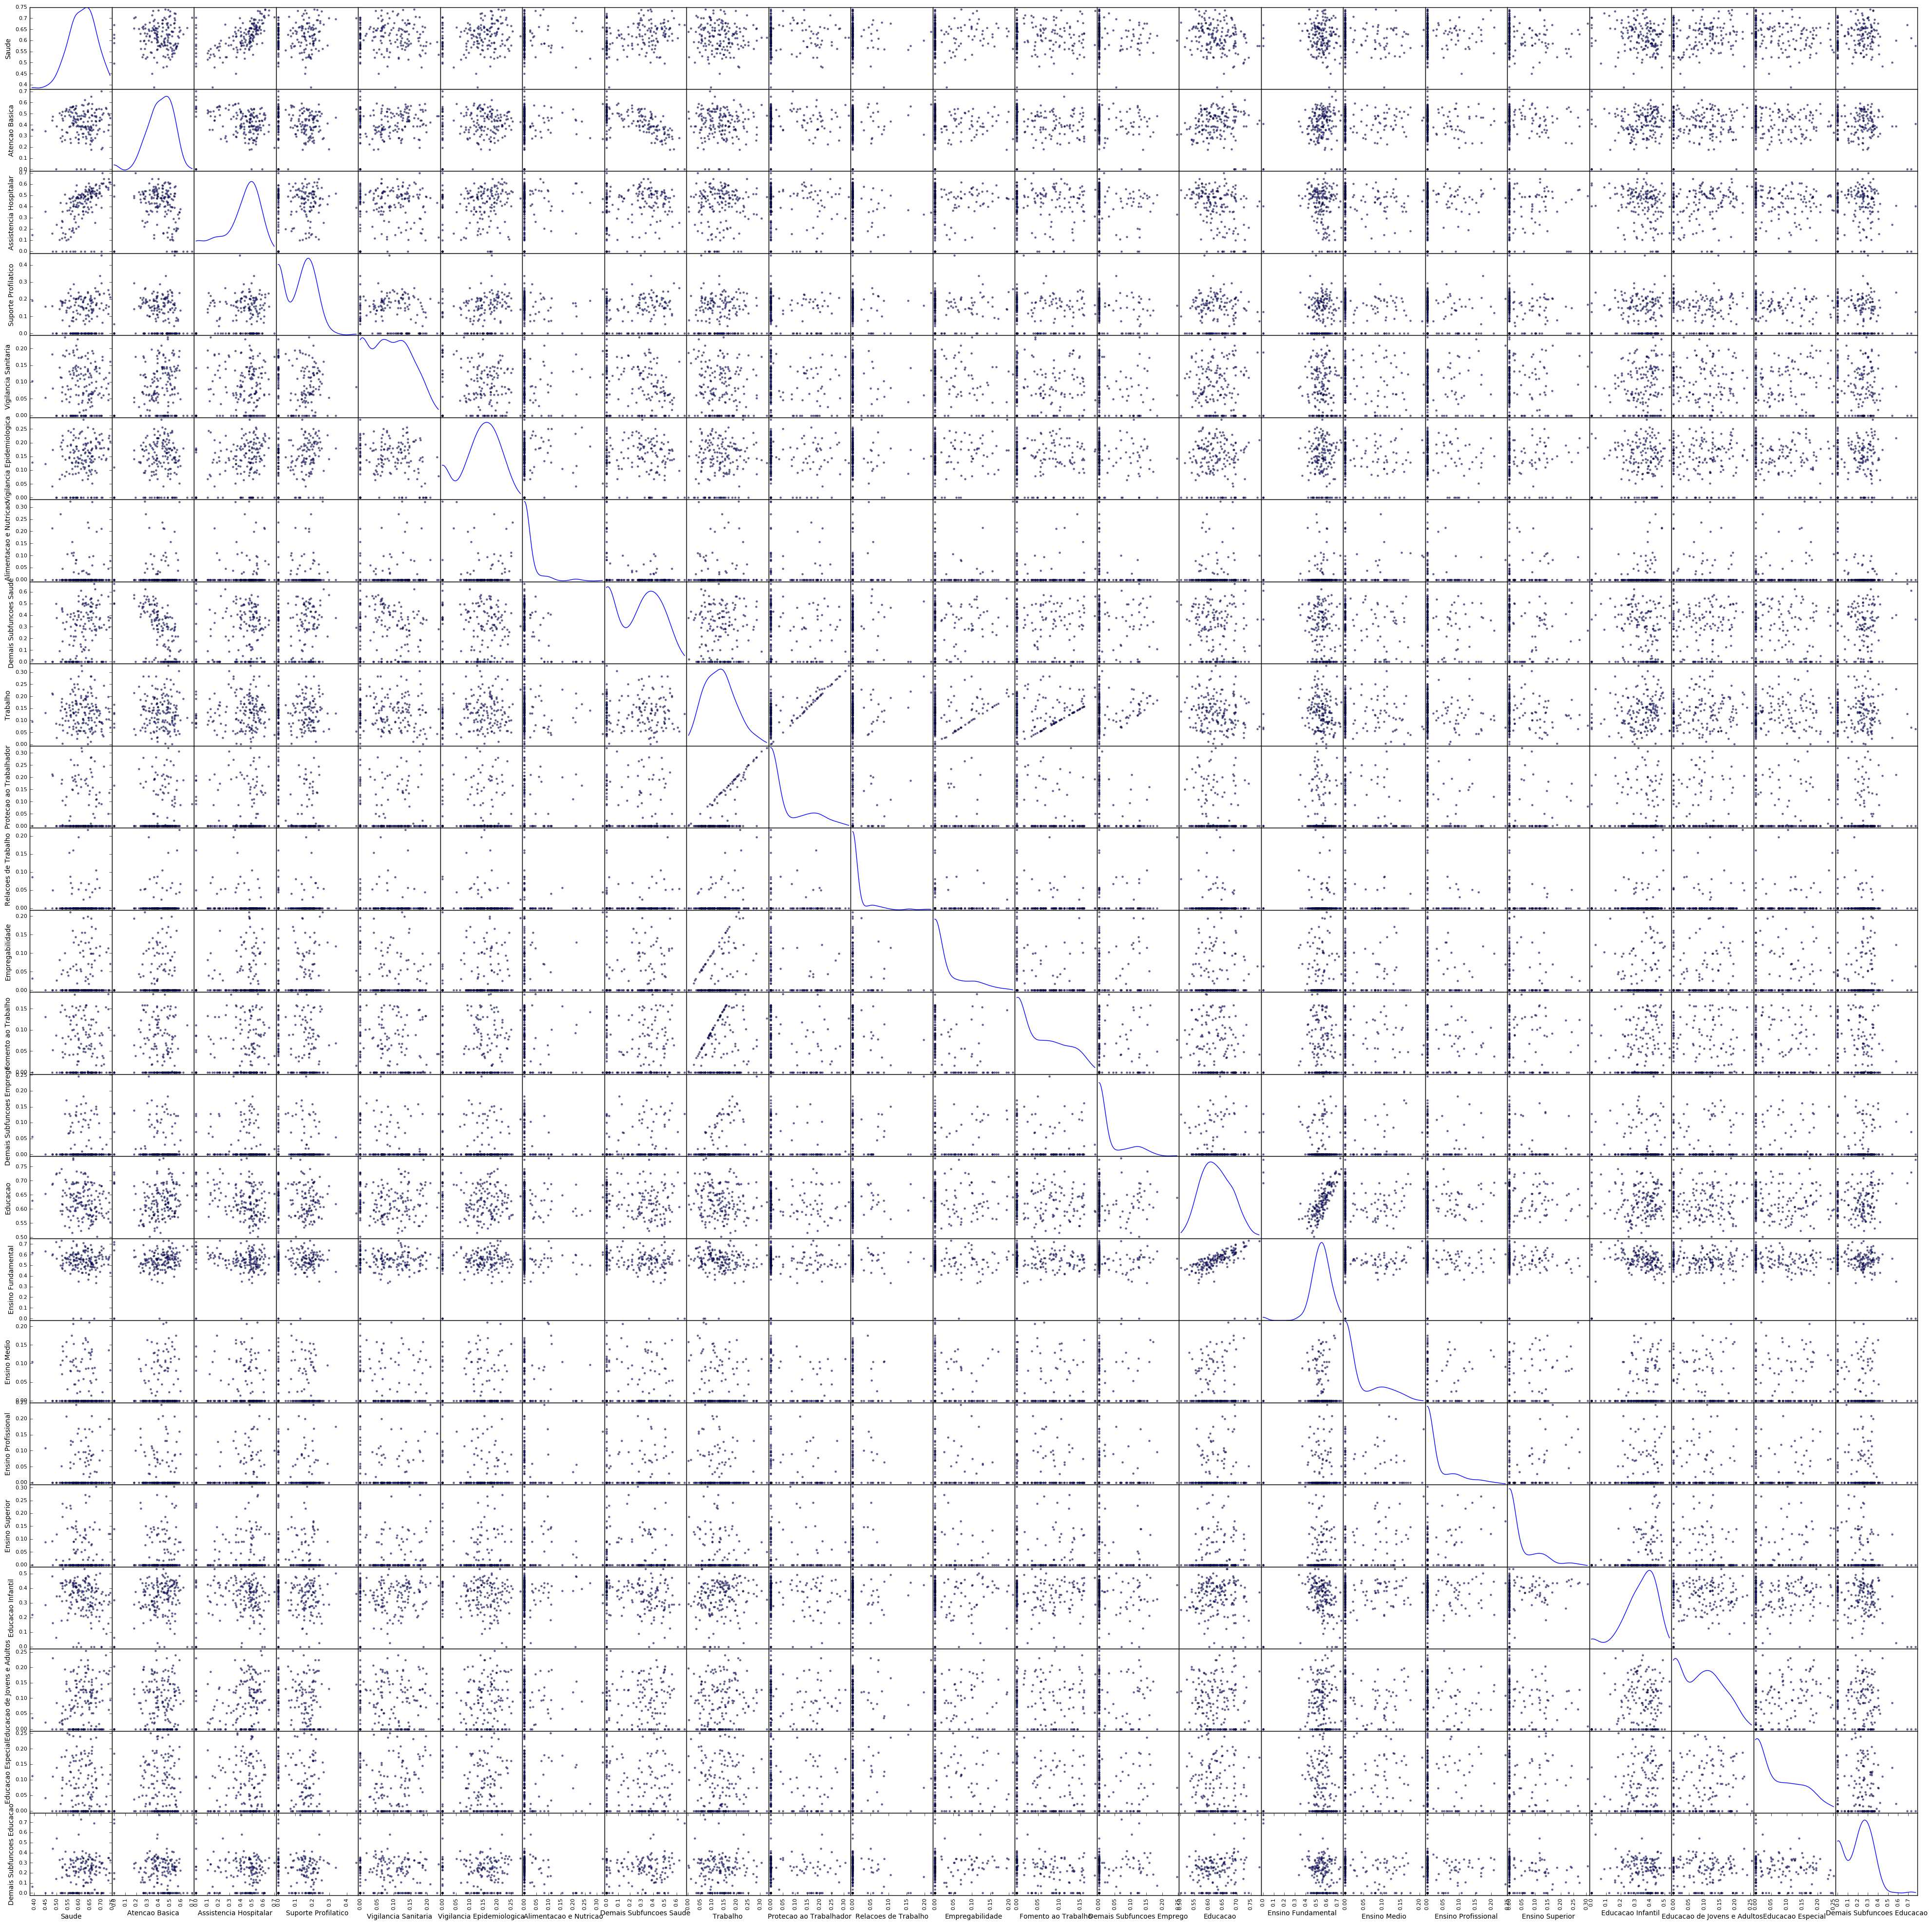

In [70]:
# Transforma os dados utilizando a raiz cubica
cbrt_gastos = np.cbrt(gastos)

# Produz um scatterplot para cada par de features
pd.scatter_matrix(cbrt_gastos, figsize = (50,50), diagonal = 'kde');

In [71]:
# retirando outliers

# Inicianilizando vetor vazio de outliers
#data = cbrt_gastos
    
#outliers = np.empty(0, dtype=int)
#for feature in data.keys():
    
#    Q1 = np.percentile(data[feature], 25)
#    Q3 = np.percentile(data[feature], 75)
    
#    step = np.multiply(1.5, Q3-Q1)
    
    # Mostra os outliers
#    out = data[~((data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))]
#    print "Data points considered outliers for the feature '{}':".format(feature)
#    display(out)
    
    # Select the indices for data points you wish to remove
#    outliers = np.append(outliers, out.index.values)

In [72]:
# Remove Trabalho, Educacao e Saude
cbrt_gastos.drop(['Saude', 'Educacao', 'Trabalho'], axis = 1, inplace = True)

# Agrupamentos por gastos

## Maiores cidades do Brasil

In [73]:
# Aplica o PCA. Numero de componentes igual ao numero de colunas
pca = PCA(n_components=len(cbrt_gastos.columns))
pca.fit(cbrt_gastos)

PCA(copy=True, n_components=20, whiten=False)

Dimensao  Variancia
0          1   0.296419
1          2   0.163413
2          3   0.094940
3          4   0.076532
4          5   0.061242
5          6   0.044756
6          7   0.039667
7          8   0.033068
8          9   0.030743
9         10   0.025605
10        11   0.023502
11        12   0.019555
12        13   0.017128
13        14   0.014614
14        15   0.013872
15        16   0.011689
16        17   0.011093
17        18   0.009581
18        19   0.008474
19        20   0.004106

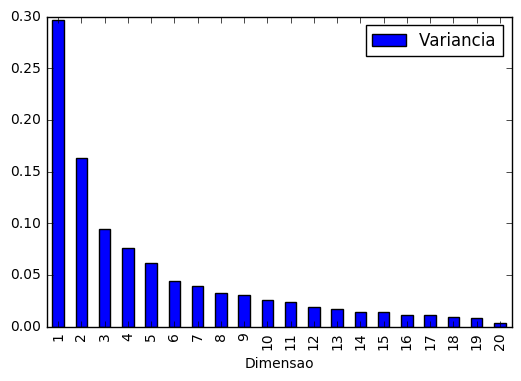

In [74]:
# Quantidade de variancia de cada componente principal
dimensoes = range(1,len(pca.components_)+1)
d = {'Variancia':pca.explained_variance_ratio_, 'Dimensao':dimensoes}
componentes = pd.DataFrame(d);

display(componentes);
componentes.plot.bar(x='Dimensao',y='Variancia');

In [75]:
# Principais atributos para cada componente
atributos_por_componente = pd.DataFrame(np.round(pca.components_, 4), columns = cbrt_gastos.keys())
atributos_por_componente.index = dimensoes
cor_area = ['g','g','g','g','g','g','g','b','b','b','b','b','r','r','r','r','r','r','r','r']

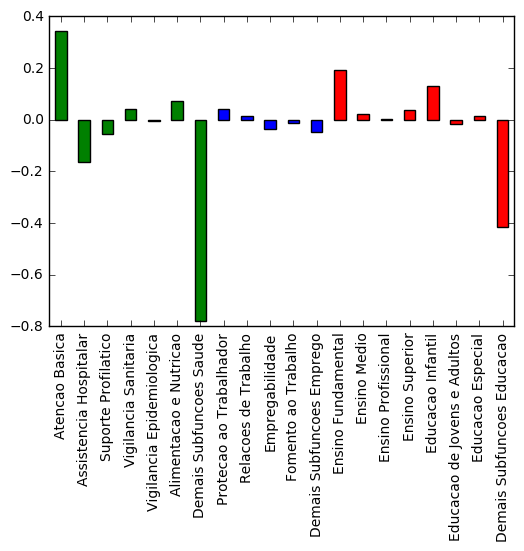

In [76]:
# Componente 1
atributos_por_componente.iloc[0,:].plot.bar(color=cor_area);

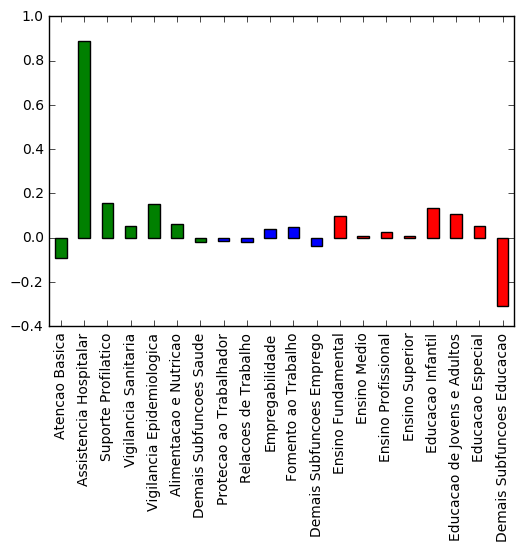

In [77]:
# Componente 2
atributos_por_componente.iloc[1,:].plot.bar(color=cor_area);

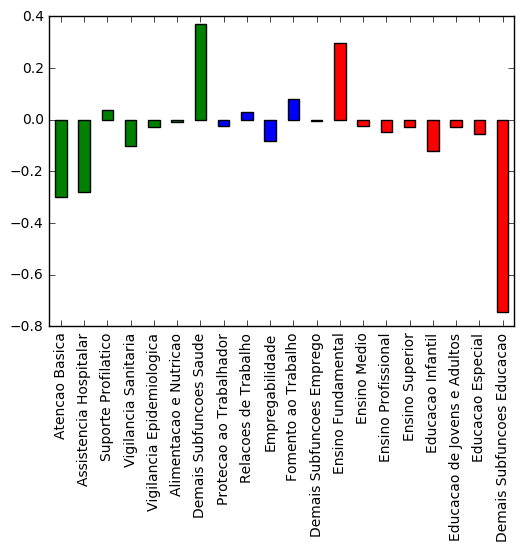

In [78]:
# Componente 3
atributos_por_componente.iloc[2,:].plot.bar(color=cor_area);

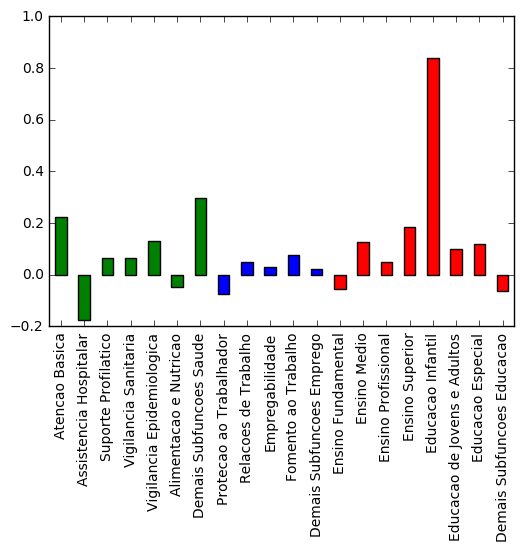

In [79]:
# Componente 4
atributos_por_componente.iloc[3,:].plot.bar(color=cor_area);

In [80]:
# Aplica o PCA e faz o fitting dos dados utilizando quatro dimensoes
pca = PCA(n_components=4)
pca.fit(cbrt_gastos)

# Transforma os dados utilizando o pca
dados_reduzidos = pca.transform(cbrt_gastos)

# Cria um dataframe para os dados em dimensoes reduzidas
dados_reduzidos = pd.DataFrame(dados_reduzidos, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4'])

In [81]:
display(dados_reduzidos.head())

Dimension 1  Dimension 2  Dimension 3  Dimension 4
0    -0.322423    -0.054991     0.078217     0.008131
1     0.339289    -0.194517     0.142727    -0.071931
2    -0.049523     0.020906     0.035761     0.066917
3    -0.290722    -0.039677     0.083352    -0.018023
4    -0.120193     0.039191    -0.050700    -0.021291

In [82]:
# Cria cluster e compara mostra os silhouettes
def cluster_silhouette(n_clusters, data):

    clusterer = KMeans(n_clusters, random_state=0)
    clusterer = clusterer.fit(data)

    preds = clusterer.predict(data)

    score = silhouette_score(data, preds)

    return (score, clusterer)

for x in range(2, 10):
    print "number of clusters: {}, silhouette score: {}".format(x, cluster_silhouette(x, dados_reduzidos)[0])

number of clusters: 2, silhouette score: 0.333289426128
number of clusters: 3, silhouette score: 0.311860796745
number of clusters: 4, silhouette score: 0.338920787538
number of clusters: 5, silhouette score: 0.256903442099
number of clusters: 6, silhouette score: 0.268783682272
number of clusters: 7, silhouette score: 0.266005880123
number of clusters: 8, silhouette score: 0.248879975531
number of clusters: 9, silhouette score: 0.258944014438


In [87]:
# Atribui cada ponto a um cluster

# Melhor cluster de acordo com silhouette
grupos = cluster_silhouette(4, dados_reduzidos)[1]

# Atribui os pontos aos clusters
preds = grupos.predict(dados_reduzidos)

# Acha o centro dos clusters
centros = grupos.cluster_centers_

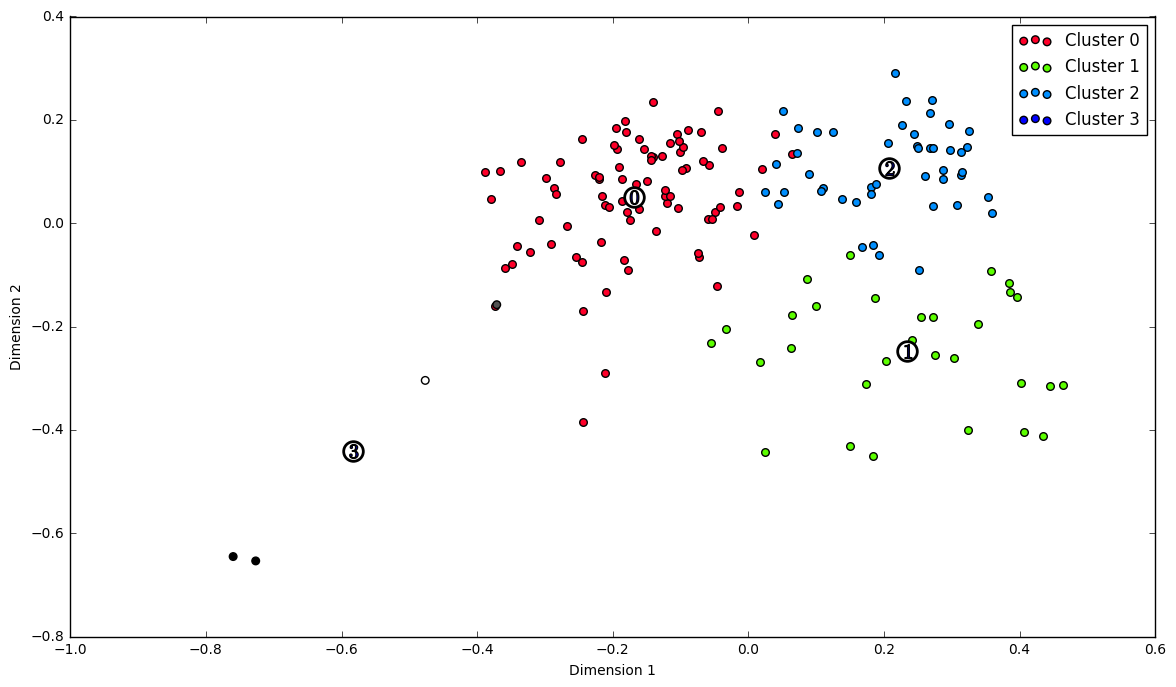

In [88]:
# Display the results of the clustering from implementation
vs.cluster_results(dados_reduzidos, preds, centros);

In [89]:
# Adiciona cluster a tabela original de cidades
cidades_300_mais_hab.insert(0, 'Grupo', preds)

## Analise de grupos

In [90]:
# Analise de ifdm
cidade_ifdm_grupo = cidades_300_mais_hab.loc[:,['ifdm_dif_saude',
 'ifdm_dif_empregoRenda',
 'ifdm_dif_educacao',
 'Regiao',
 'UF', 'Municipio',
 'Grupo']]

cidade_ifdm_dif_grupo = cidades_300_mais_hab.loc[:,['2012_saude_nota',
 '2012_empregoRenda_nota',
 '2012_educacao_nota',
 'Regiao',
 'UF', 'Municipio',
 'Grupo']]


In [91]:
# Cria grafico de barras com legendas por fora da figura
def grafico_barras(df, titulo):
    f = plt.figure()
    plt.title(titulo)
    df.plot(kind='bar', ax=f.gca())
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

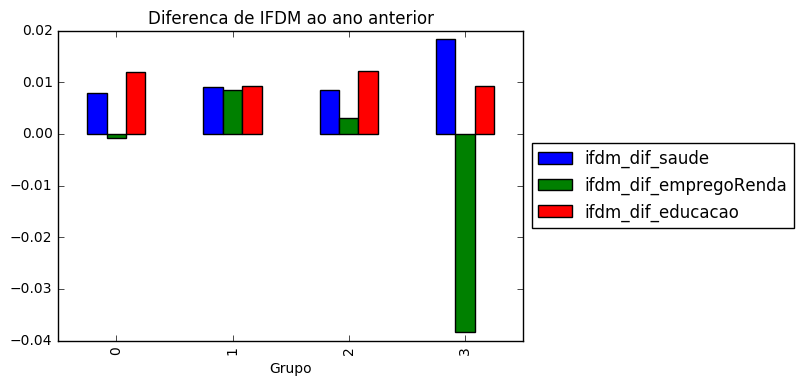

In [92]:
ifdm_grupos = cidade_ifdm_grupo.groupby('Grupo').mean();

grafico_barras(ifdm_grupos, "Diferenca de IFDM ao ano anterior");

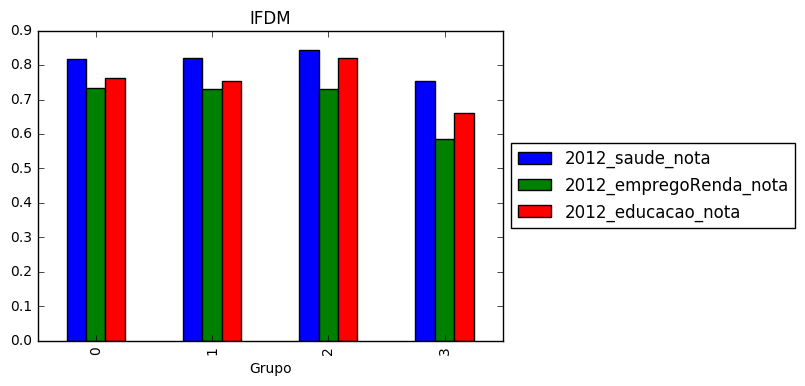

In [93]:
ifdm_dif_grupos = cidade_ifdm_dif_grupo.groupby('Grupo').mean();
grafico_barras(ifdm_dif_grupos, "IFDM");

In [94]:
# Tamanho das cidades dos grupos
tam_grupo = cidades_300_mais_hab.loc[:,['Tamanho','Grupo']]
for grupo in tam_grupo.Grupo.unique():
    print "Grupo: {}".format(grupo);
    display(tam_grupo[tam_grupo.Grupo == grupo].Tamanho.value_counts());


Grupo: 0


Media           41
Media-grande    18
Grande          14
Metropole       11
Name: Tamanho, dtype: int64

Grupo: 1


Media           27
Media-grande     3
Name: Tamanho, dtype: int64

Grupo: 2


Media           35
Media-grande     5
Grande           4
Metropole        2
Name: Tamanho, dtype: int64

Grupo: 3


Media           2
Media-grande    1
Grande          1
Name: Tamanho, dtype: int64

Saude  Trabalho  Educacao
Grupo                              
0      0.267120  0.004349  0.236823
1      0.180398  0.004315  0.287873
2      0.234691  0.004014  0.252807
3      0.233448  0.003709  0.355080

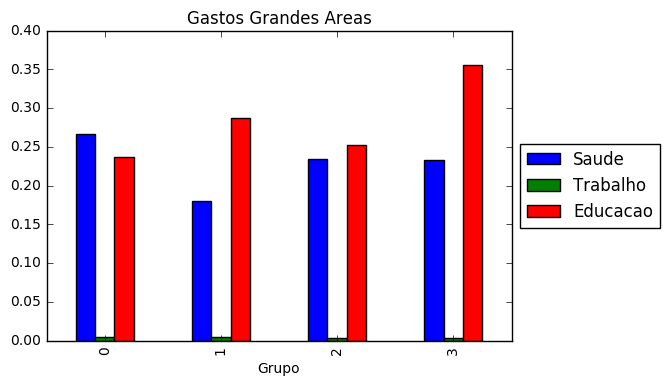

In [99]:
saude_grupo = cidades_300_mais_hab.loc[:,['Grupo','Saude','Trabalho','Educacao']]
sg_ste = saude_grupo.groupby('Grupo').mean();
display(sg_ste)
    
grafico_barras(sg_ste, "Gastos Grandes Areas");

Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
Grupo                                                                
0            0.060217                0.117013             0.006493   
1            0.155950                0.006076             0.002391   
2            0.097832                0.122847             0.003538   
3            0.031501                0.033280             0.003963   

       Vigilancia Sanitaria  Vigilancia Epidemiologica  \
Grupo                                                    
0                  0.001141                   0.004883   
1                  0.002346                   0.003151   
2                  0.002149                   0.004295   
3                  0.001835                   0.002559   

       Alimentacao e Nutricao  Demais Subfuncoes Saude  
Grupo                                                   
0                    0.000039                 0.077334  
1                    0.000383                 0.010100  
2                    0.002951                 0.001079  
3                    0.000005                 0.160304

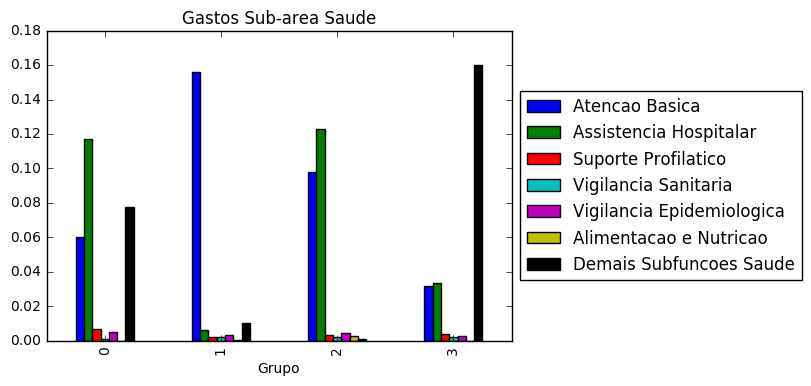

In [100]:
# Gastos das cidades em saude
saude_grupo = cidades_300_mais_hab.loc[:,['Grupo','Atencao Basica','Assistencia Hospitalar','Suporte Profilatico','Vigilancia Sanitaria','Vigilancia Epidemiologica','Alimentacao e Nutricao','Demais Subfuncoes Saude']]
sg_f = saude_grupo.groupby('Grupo').mean();
display(sg_f)
    
grafico_barras(sg_f, "Gastos Sub-area Saude");

Protecao ao Trabalhador  Relacoes de Trabalho  Empregabilidade  \
Grupo                                                                   
0                     0.002007              0.000130         0.000680   
1                     0.003198              0.000176         0.000202   
2                     0.002200              0.000312         0.000511   
3                     0.002309              0.000000         0.000520   

       Fomento ao Trabalho  Demais Subfuncoes Emprego  
Grupo                                                  
0                 0.000901                   0.000631  
1                 0.000441                   0.000298  
2                 0.000690                   0.000300  
3                 0.000004                   0.000876

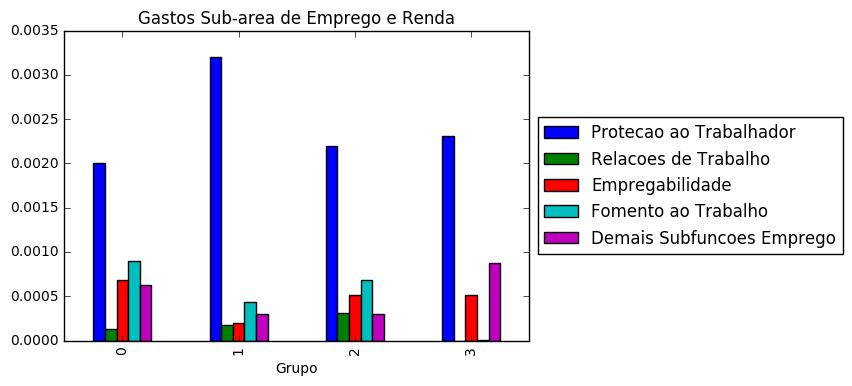

In [101]:
# Gastos das cidades em emprego e renda
emprego_grupo = cidades_300_mais_hab.loc[:,['Grupo','Protecao ao Trabalhador','Relacoes de Trabalho','Empregabilidade','Fomento ao Trabalho','Demais Subfuncoes Emprego']]
sg_er = emprego_grupo.groupby('Grupo').mean();
display(sg_er)

grafico_barras(sg_er, "Gastos Sub-area de Emprego e Renda");

Ensino Fundamental  Ensino Medio  Ensino Profissional  Ensino Superior  \
Grupo                                                                           
0                0.163729      0.000442             0.000549         0.001063   
1                0.210440      0.000544             0.000400         0.001437   
2                0.181168      0.000847             0.000759         0.001351   
3                0.010530      0.000000             0.000000         0.000000   

       Educacao Infantil  Educacao de Jovens e Adultos  Educacao Especial  \
Grupo                                                                       
0               0.044781                      0.002119           0.001730   
1               0.056841                      0.001214           0.000886   
2               0.055108                      0.002349           0.002387   
3               0.000005                      0.000000           0.000003   

       Demais Subfuncoes Educacao  
Grupo                              
0                        0.022410  
1                        0.016112  
2                        0.008838  
3                        0.344541

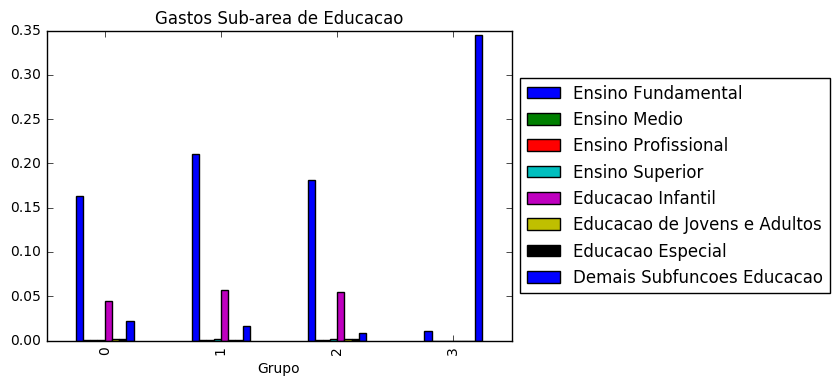

In [102]:
# Gastos das cidades em educacao
educacao_grupo = cidades_300_mais_hab.loc[:,['Grupo','Ensino Fundamental','Ensino Medio','Ensino Profissional','Ensino Superior','Educacao Infantil','Educacao de Jovens e Adultos','Educacao Especial','Demais Subfuncoes Educacao',]]
sg_e = educacao_grupo.groupby('Grupo').mean();
display(sg_e)

grafico_barras(sg_e, "Gastos Sub-area de Educacao");

## Maiores cidades por região

## Maiores cidades por UF